In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.losses import CategoricalCrossentropy 
import sys
from keras import optimizers

def column_one_hot (dataframe, columns): 
    for column in columns:
        if column in dataframe:
            one_hot = pd.get_dummies(dataframe[column])
            dataframe = dataframe.drop(column,axis = 1)
            dataframe = pd.concat([dataframe, one_hot], axis=1)
    return dataframe

def drop_columns (dataframe, columns):
    for column in columns:
        if column in dataframe.columns:
            dataframe = dataframe.drop(column, axis=1)
    return dataframe

def drop_column (dataframe, column):
    if column in dataframe.columns:
        dataframe = dataframe.drop(column, axis=1)
    return dataframe

def adjustShape(df_training, df_testing):
    length = df_testing.shape[0]
    df_temp = pd.concat([df_training, df_testing], ignore_index=True, sort=False)
    df_temp = df_temp.fillna(0)
    df_testing = df_temp.tail(length)
    df_training = df_temp.drop(df_temp.tail(length).index)
    return df_training, df_testing

In [19]:
df = pd.read_csv('SAR_Data.csv')

status = df['Status'].unique()

maskOpen = ((df['Status'] == 'postponed') | (df['Status'] == 'partly open') |( df['Status'] == 'In creation'))
maskClosed = (df['Status'] == 'partly closed')
df.loc[maskOpen, 'Status'] = 'open'
df.loc[maskClosed, 'Status'] = 'closed'
df.loc[(df['Status'] == 'non applicable'), 'Status'] = 'not applicable'
status = df['Status'].unique()

# postponed, partly open, in creation -> open;    partly closed -> closed

# falsche Ordnerstruktur in /RA Application Conditions/03_PG_OCS/Service and diagnostic systems
# fehlt ein Ordner bevor Module kommen, deshalb händisch eintragen

df.loc[df['Version'].str.contains('VICOS_S_D'), 'Product'] = 'VICOS_S_D'
df.loc[df['Version'].str.contains('VICOS_S_D'), 'Version'] = df['Version'].str[-5:]

paths = df['Path'].unique()
accessDB = pd.read_xml("X:/File/DE/bwga024a_IMORA_RM/05_Process_Management/14_Metriken & KPI/KPI-Erhebung/KPI_01-04_General/Data/Input/Input_BWG_Combined_Access.xml")

for path in paths:
    try:
        if(path == "/ML Realization Projects Algeria"):
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & (accessDB['Offset'] == "/ML Realization Projects Algeria/20006_ML_BM_Boughezoul_MSila")].iloc[0]
        else:
            result = accessDB.loc[(accessDB['Type'] == "Real") & (accessDB['Location'] == "BWG") & ((accessDB['Offset'] == str(path)) | (accessDB['Offset'] == (str(path) + "/")))].iloc[0]           
    except:
        print(str(path) + " has no entry in the AccessDB!")

    mask = df['Path'] == str(path)
    df.loc[mask, 'Project_category'] = result['Project_category']
    df.loc[mask, 'BS'] = result['BS']
    df.loc[mask, 'RU'] = result['RU']
    df.loc[mask, 'ProjectYear'] = result['ProjectYear']
    df.loc[mask, 'section'] = result['section']
    df.loc[mask, 'Project_name'] = result['Project_name']
    df['ProductVersion'] = df["Product"].str.cat(df["Version"], sep = "-")

df['ProjectYear'] = df['ProjectYear'].astype('int')
df = df[['Text', 'Product', 'ProductVersion', 'Project_name', 'section', 'Project_category', 'BS', 'RU', 'ProjectYear', 'Status', 'Statement']]
#df = drop_column(df, 'Statement') # später wieder löschen!


# TEST (WORKING!) ---------------------------------------
products = df['Product'].unique()
df = column_one_hot(df, ['Product'])
projects = df['Project_name'].unique()
for project in projects:
    for product in products:
        df.loc[df['Project_name'] == project, product] = 1 if (df.loc[df['Project_name'] == project][product].sum()) >= 1 else 0
df = column_one_hot(df, ['ProductVersion', 'Project_name', 'section',
       'Project_category', 'BS', 'RU', 'ProjectYear'])
df.shape


(14572, 180)

In [20]:
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text].reset_index(drop=True)

test_col = 8
test = drop_columns(df_training.iloc[[test_col]], ['Text', 'Status', 'Statement'])
df_training = df_training.drop(test_col)

df_training = df_training.sample(frac=1).reset_index(drop=True)

trainX = drop_columns(df_training, ['Status', 'Text', 'Statement'])
trainYStatus = drop_column(column_one_hot(df_training[['Text', 'Status']], ['Status']), "Text")
trainYStatement = drop_column(column_one_hot(df_training[['Text', 'Statement']], ['Statement']), "Text")
trainX.shape

(16, 177)

In [27]:
#Functional
inputs = Input(shape=(trainX.shape[1],))
x = Dense(32, activation='relu')(inputs)
x = Dense(16, activation='relu')(x)
output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
model = Model(inputs=inputs, outputs=[output1, output2])
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                metrics=['categorical_accuracy'])

history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                    batch_size=1,
                    epochs=25,
                    verbose=0,
                    validation_split=0.4)

prediction_status, prediction_statement = model.predict(test)

for val in prediction_status:
    for col in range(len(val)):
        print (str(trainYStatus.columns[col]) + " " + '{:.1%}'.format(val[col]))

index_max = np.argmax(prediction_statement)
for val in prediction_statement:
    print (trainYStatement.columns[index_max] + " " + '{:.1%}'.format(val[index_max]))
#col = 0
#for i in predictionStatement:
#    for j in i:
#        print (trainYStatement.columns[col] + " " + '{:.1%}'.format(j))
#        col += 1
#

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 177)]        0           []                               
                                                                                                  
 dense_28 (Dense)               (None, 32)           5696        ['input_15[0][0]']               
                                                                                                  
 dense_29 (Dense)               (None, 16)           528         ['dense_28[0][0]']               
                                                                                                  
 status (Dense)                 (None, 3)            51          ['dense_29[0][0]']               
                                                                                           

([<matplotlib.patches.Wedge at 0x26a363778e0>,
 [Text(0.42095177560159885, 1.0162674857624154, 'closed'),
  Text(-1.0788638084435536, -0.2145993542177412, 'compliant'),
  Text(0.6111272563215621, -0.9146165735328001, 'not applicable')],
 [Text(0.22961005941905388, 0.5543277195067721, '37.5%'),
  Text(-0.5884711682419382, -0.11705419320967701, '31.2%'),
  Text(0.3333421398117611, -0.49888176738152723, '31.2%')])

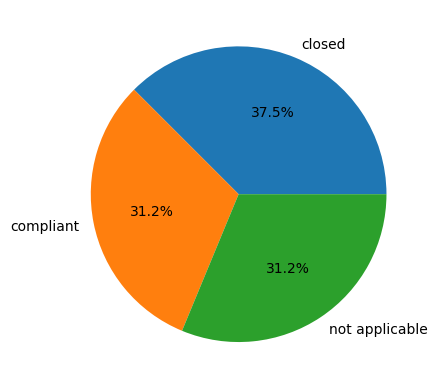

In [30]:
hauefigkeit = [trainYStatus['closed'].sum(), trainYStatus['compliant'].sum(), trainYStatus['not applicable'].sum()]
status = ('closed', 'compliant', 'not applicable')


fig, ax = plt.subplots()
ax.pie(hauefigkeit, labels=status, autopct='%1.1f%%')


In [ ]:
# Tests below---------------------------------------------------------------------------

In [ ]:
all_adam = []
all_rmsprop = []
all_sgd = []

In [ ]:
all_adam = []
all_adam_small = []
all_adam_large = []

In [ ]:
# k-cross Validierung
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text]
df_training = df_training.sample(frac=1).reset_index(drop=True)

#all_val_loss = []
#all_loss     = []
#all_acc     = []
#all_val_acc = []

num_epochs = 250
k = 4
for i in range(k):
    start = int(i/k * len(df_training))
    end = int((i/k + 0.25) * len(df_training))
    val_data = df_training.iloc[start:end] 
    train_data = df_training.drop(range(start,end))

    trainX = drop_columns(train_data, ['Status', 'Text', 'Statement'])
    trainYStatus = drop_column(column_one_hot(train_data[['Text', 'Status']], ['Status']), "Text")
    trainYStatement = drop_column(column_one_hot(train_data[['Text', 'Statement']], ['Statement']), "Text")

    valX = drop_columns(val_data, ['Status', 'Text', 'Statement'])
    trainX, valX = adjustShape(trainX, valX)

    valYStatus = drop_column(column_one_hot(val_data[['Text', 'Status']], ['Status']), "Text")
    trainYStatus, valYStatus = adjustShape(trainYStatus, valYStatus)

    valYStatement = drop_column(column_one_hot(val_data[['Text', 'Statement']], ['Statement']), "Text")
    trainYStatement, valYStatement = adjustShape(trainYStatement, valYStatement)

    inputs = Input(shape=(trainX.shape[1],))
    x = Dense(8, activation='relu')(inputs)
    x = Dense(16, activation='relu')(x)
    output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
    output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
    model = Model(inputs=inputs, outputs=[output1, output2])
    model.summary()

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                    loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                    metrics=['categorical_accuracy'])

    history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                        batch_size=1,
                        epochs=num_epochs,
                        verbose=2,
                        validation_data = (valX, {'status': valYStatus, 'statement': valYStatement}))
    all_adam_small.append(history.history['val_status_loss'])
    #all_val_loss.append(history.history['val_status_loss'])
    #all_loss.append(history.history['status_loss'])
    #all_acc.append(history.history['status_categorical_accuracy'])
    #all_val_acc.append(history.history['val_status_categorical_accuracy'])

In [ ]:
# k-cross-Validierung
adam        = [np.mean([x[i] for x in all_adam])
                    for i in range(num_epochs-1)]
rmsprop     = [np.mean([x[i] for x in all_rmsprop])
                    for i in range(num_epochs-1)]
sgd         = [np.mean([x[i] for x in all_sgd])
                    for i in range(num_epochs-1)]


plt.plot(range(1, len(adam) + 1), adam, label = 'Adam-Optimierer')
plt.plot(range(1, len(rmsprop) + 1), rmsprop, label = 'RMSprop-Optimierer')
plt.plot(range(1, len(sgd) + 1), sgd, label = 'SGD-Optimierer')
plt.title('Mittlerer Wert der Verlustfunktion')
plt.xlabel('Epochen')
plt.legend()


In [ ]:
# k-cross-Validierung
adam        = [np.mean([x[i] for x in all_adam])
                    for i in range(num_epochs-1)]
adamS     = [np.mean([x[i] for x in all_adam_small])
                    for i in range(num_epochs-1)]
adamL         = [np.mean([x[i] for x in all_adam_large])
                    for i in range(num_epochs-1)]


plt.plot(range(1, len(adam) + 1), adam, label = 'Lr = 0,001')
plt.plot(range(1, len(adamS) + 1), adamS, label = 'Lr = 0,0001')
plt.plot(range(1, len(adamL) + 1), adamL, label = 'Lr = 0,01')
plt.title('Mittlerer Wert der Verlustfunktion')
plt.xlabel('Epochen')
plt.legend()



In [ ]:
# Test verschiedener Architekturen
m1_all = []
m2_all = []
m3_all = []
m4_all = []
m5_all = []


In [ ]:
df_training = df
text = "Zur Anschaltung des Antriebes in der Außenanlage müssen Signalkabel nach VDE 0816/2 oder Kabel mit vergleichbaren Eigenschaften verwendet werden. Die Verlegevorschriften des Kabels sind einzuhalten."
df_training = df_training.loc[df_training['Text'] == text]
df_training = df_training.sample(frac=1).reset_index(drop=True)

num_epochs = 250
k = 4
for i in range(k):
    start = int(i/k * len(df_training))
    end = int((i/k + 0.25) * len(df_training))
    val_data = df_training.iloc[start:end] 
    train_data = df_training.drop(range(start,end))

    trainX = drop_columns(train_data, ['Status', 'Text', 'Statement'])
    trainYStatus = drop_column(column_one_hot(train_data[['Text', 'Status']], ['Status']), "Text")
    trainYStatement = drop_column(column_one_hot(train_data[['Text', 'Statement']], ['Statement']), "Text")

    valX = drop_columns(val_data, ['Status', 'Text', 'Statement'])
    trainX, valX = adjustShape(trainX, valX)

    valYStatus = drop_column(column_one_hot(val_data[['Text', 'Status']], ['Status']), "Text")
    trainYStatus, valYStatus = adjustShape(trainYStatus, valYStatus)

    valYStatement = drop_column(column_one_hot(val_data[['Text', 'Statement']], ['Statement']), "Text")
    trainYStatement, valYStatement = adjustShape(trainYStatement, valYStatement)
# -----------------------------------------------------------------------------------------------------------------
    inputs = Input(shape=(trainX.shape[1],))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(16, activation='relu')(x)
    output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
    output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
    model = Model(inputs=inputs, outputs=[output1, output2])
    model.summary()

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                    metrics=['categorical_accuracy'])

    history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                        batch_size=1,
                        epochs=num_epochs,
                        verbose=2,
                        validation_data = (valX, {'status': valYStatus, 'statement': valYStatement}))
    m1_all.append(history.history['val_status_loss'])
# -----------------------------------------------------------------------------------------------------------------
    inputs = Input(shape=(trainX.shape[1],))
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
    output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
    model = Model(inputs=inputs, outputs=[output1, output2])
    model.summary()

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                    metrics=['categorical_accuracy'])

    history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                        batch_size=1,
                        epochs=num_epochs,
                        verbose=2,
                        validation_data = (valX, {'status': valYStatus, 'statement': valYStatement}))
    m2_all.append(history.history['val_status_loss'])
# -----------------------------------------------------------------------------------------------------------------
    inputs = Input(shape=(trainX.shape[1],))
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
    output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
    model = Model(inputs=inputs, outputs=[output1, output2])
    model.summary()

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                    metrics=['categorical_accuracy'])

    history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                        batch_size=1,
                        epochs=num_epochs,
                        verbose=2,
                        validation_data = (valX, {'status': valYStatus, 'statement': valYStatement}))
    m3_all.append(history.history['val_status_loss'])
# -----------------------------------------------------------------------------------------------------------------
    inputs = Input(shape=(trainX.shape[1],))
    x = Dense(16, activation='relu')(inputs)
    output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
    output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
    model = Model(inputs=inputs, outputs=[output1, output2])
    model.summary()

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                    metrics=['categorical_accuracy'])

    history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                        batch_size=1,
                        epochs=num_epochs,
                        verbose=2,
                        validation_data = (valX, {'status': valYStatus, 'statement': valYStatement}))
    m4_all.append(history.history['val_status_loss'])
# -----------------------------------------------------------------------------------------------------------------
    inputs = Input(shape=(trainX.shape[1],))
    x = Dense(512, activation='relu')(inputs)
    output1 = Dense(trainYStatus.shape[1], activation='softmax', name='status')(x)
    output2 = Dense(trainYStatement.shape[1], activation='softmax', name='statement')(x)
    model = Model(inputs=inputs, outputs=[output1, output2])
    model.summary()

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss={'status': CategoricalCrossentropy(), 'statement': CategoricalCrossentropy()},
                    metrics=['categorical_accuracy'])

    history = model.fit(trainX, {'status': trainYStatus, 'statement': trainYStatement},
                        batch_size=1,
                        epochs=num_epochs,
                        verbose=2,
                        validation_data = (valX, {'status': valYStatus, 'statement': valYStatement}))
    m5_all.append(history.history['val_status_loss'])


In [ ]:
# k-cross-Validierung
m1          = [np.mean([x[i] for x in m1_all])
                    for i in range(num_epochs-1)]
m2          = [np.mean([x[i] for x in m2_all])
                    for i in range(num_epochs-1)]
m3          = [np.mean([x[i] for x in m3_all])
                    for i in range(num_epochs-1)]
m4          = [np.mean([x[i] for x in m4_all])
                    for i in range(num_epochs-1)]
m5          = [np.mean([x[i] for x in m5_all])
                    for i in range(num_epochs-1)]

plt.plot(range(1, len(m1) + 1), m1, label = 'M1')
plt.plot(range(1, len(m2) + 1), m2, label = 'M2')
plt.plot(range(1, len(m3) + 1), m3, label = 'M3')
plt.plot(range(1, len(m4) + 1), m4, label = 'M4')
plt.plot(range(1, len(m5) + 1), m5, label = 'M5')
plt.title('Mittlerer Wert der Verlustfunktion')
plt.xlabel('Epochen')
plt.legend()


In [ ]:
m1Test = m1
index_min = np.argmin(m1Test)
m1Test[index_min]